In [105]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

In [106]:
import os
dir_name = os.path.abspath('.')
dir_name

'f:\\Code\\python\\python_qiang\\gbdt'

In [107]:
csv_file = os.path.join(dir_name, 'new_data.csv')

# 加载CSV数据
data = pd.read_csv(os.path.join(dir_name, 'new_data.csv'), encoding='gb2312')
data = data[data['Distance'] > 40]

# 对data的所有非数值列进行log运算
data = data.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)


# 提取输入特征和标签
features = data.drop(['Flow', 'o', 'd', 'province', 'pro_border', 'hu_border', 'Var4'], axis=1).dropna()
labels = data['Var4'].dropna().values.reshape(-1, 1)


In [108]:
# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=42)

In [109]:
def plot_partial_depency(model, data, province: str=None):
    dst_data = data
    if province is not None:
        dst_data = data[data['province']==province]
    X = dst_data.drop(['Flow', 'o', 'd', 'province', 'pro_border', 'hu_border', 'Var4'], axis=1).dropna()

    # 使用pdp计算部分依赖值
    features_index = [0]  # 需要计算部分依赖的特征的索引
    pd_results = partial_dependence(model, X, features_index, kind='both', grid_resolution=100)

    # 绘制部分依赖曲线
    fig, axs = plt.subplots(len(features_index), 1, figsize=(8, 6 * len(features_index)))

    if len(features_index) == 1:
        axs = [axs]  # 处理只有一个特征时的情况

    for i, ax in enumerate(axs):
        ax.plot(pd_results['values'][i], pd_results['average'][i])
        ax.set_xlabel(f'Feature {X.columns[features_index[i]]}')
        ax.set_ylabel('Partial Dependence')

    plt.tight_layout()
    plt.show()

In [110]:
def pred_plot(data: pd.DataFrame, province: str=None):
    dst_data = data
    if province is not None:
        dst_data = data[data['province']==province]
    X = dst_data.drop(['Flow', 'o', 'd', 'province', 'pro_border', 'hu_border', 'Var4'], axis=1).dropna()
    y = dst_data['Var4'].dropna().values.reshape(-1, 1)
    y_pred = model.predict(X)

    plot_x = X['Distance'].to_numpy()
    plot_val_y = y.ravel()
    sorted_indices = sorted(range(len(plot_x)), key=lambda i: plot_x[i])
    x_sorted = [plot_x[i] for i in sorted_indices]
    y_sorted = [plot_val_y[i] for i in sorted_indices]
    y_pred_sorted = [y_pred[i] for i in sorted_indices]

    # 创建matplotlib图形对象
    fig, ax = plt.subplots()

    # 绘制线型图
    ax.plot(x_sorted, y_sorted, label='real')
    ax.plot(x_sorted, y_pred_sorted, label='predict')

    # 显示图形
    plt.show()

In [111]:
def look_model_train_result(model, province):
    # 在验证集上进行预测
    y_pred = model.predict(X_val)
    plot_x = X_val['Distance'].to_numpy()
    plot_val_y = y_val.ravel()
    sorted_indices = sorted(range(len(plot_x)), key=lambda i: plot_x[i])
    x_sorted = [plot_x[i] for i in sorted_indices]
    y_sorted = [plot_val_y[i] for i in sorted_indices]
    y_pred_sorted = [y_pred[i] for i in sorted_indices]

    # 创建matplotlib图形对象
    fig, ax = plt.subplots()

    # 绘制线型图
    ax.plot(x_sorted, y_sorted, label='real')
    ax.plot(x_sorted, y_pred_sorted, label='predict')

    # 显示图形
    plt.show()

    plot_partial_depency(model, data, province)

    pred_plot(data, province)

# GBDT

In [112]:
# 创建GBDT回归模型
model = GradientBoostingRegressor(n_estimators=1000, 
                                  max_depth=4, 
                                  learning_rate=0.01, 
                                  subsample=0.5, 
                                  min_samples_split=5)

# 训练模型
model.fit(X_train, y_train.ravel())


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, min_samples_split=5,
                          n_estimators=1000, subsample=0.5)

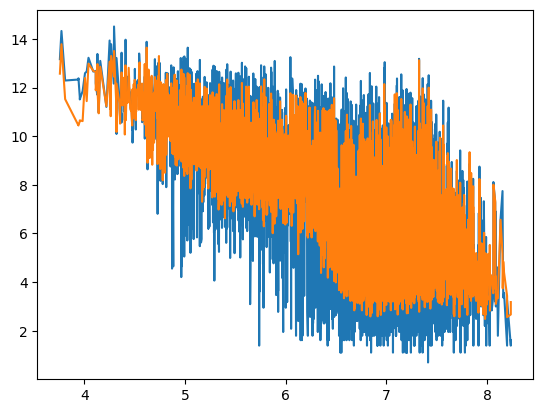

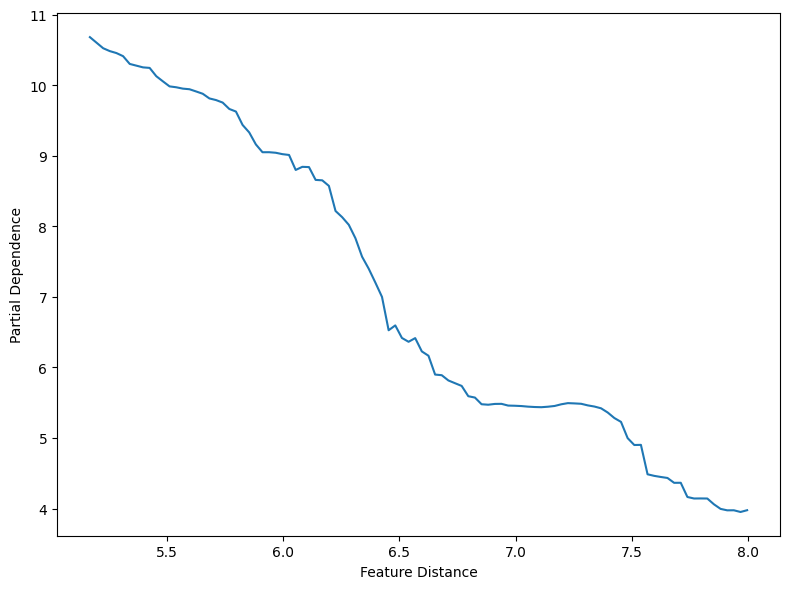

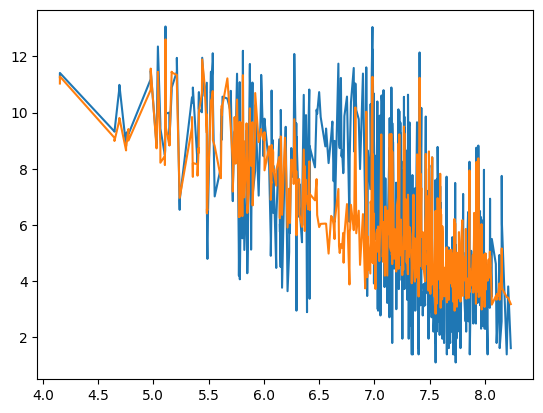

In [113]:
look_model_train_result(model, 'Heilongjiang')

# RandomForestRegressor

In [114]:
from sklearn.ensemble import RandomForestRegressor
# 创建回归模型
forest_model = RandomForestRegressor(n_estimators=1000, 
                                  max_depth=4,
                                  min_samples_split=5)

# 训练模型
forest_model.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=1000)

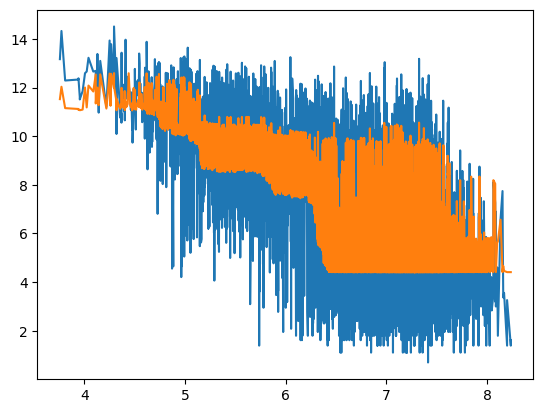

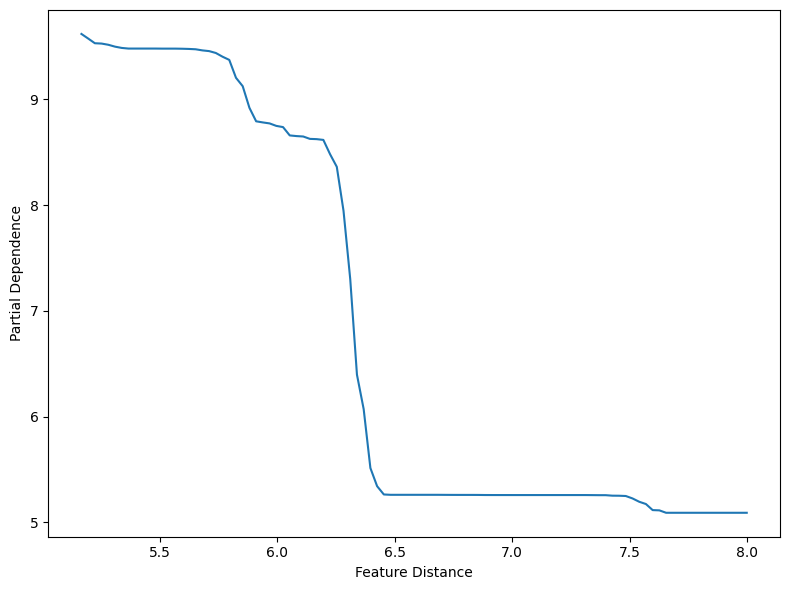

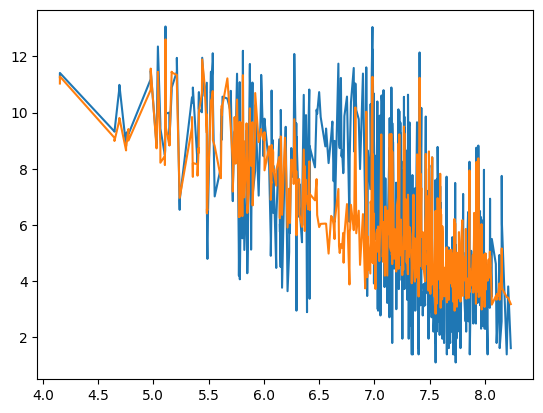

In [115]:
look_model_train_result(forest_model, 'Heilongjiang')

# XGBoost

In [116]:
from xgboost import XGBRegressor
xgboost_model = XGBRegressor(n_estimators=1000,
                     max_depth=4,
                     learning_rate=0.01,
                     subsample=0.5)
xgboost_model.fit(X_train, y_train.ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

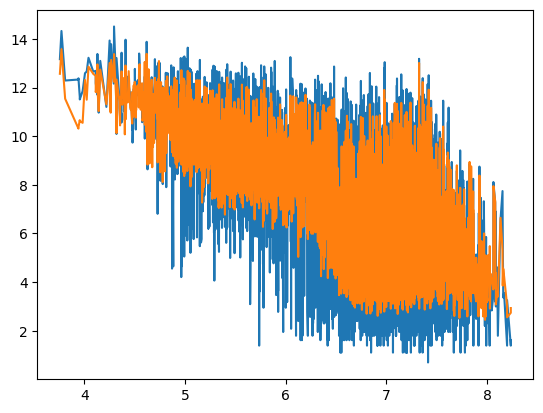

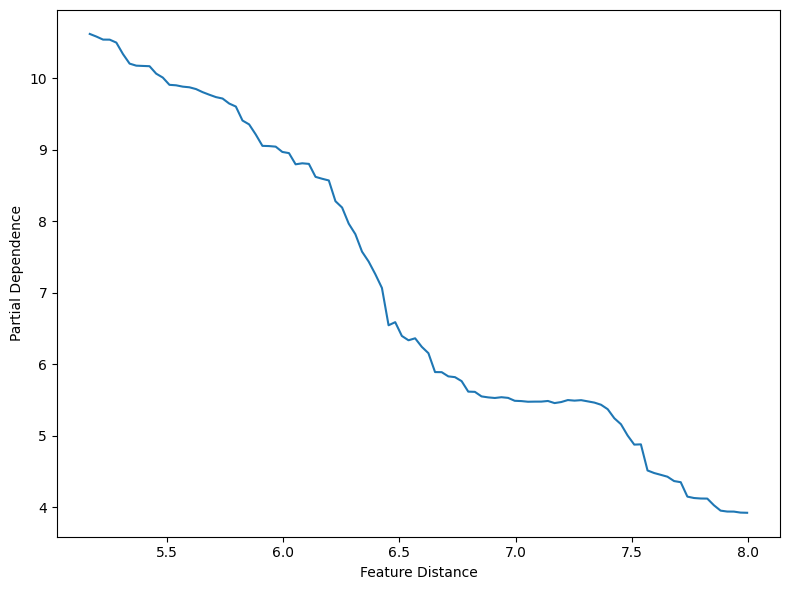

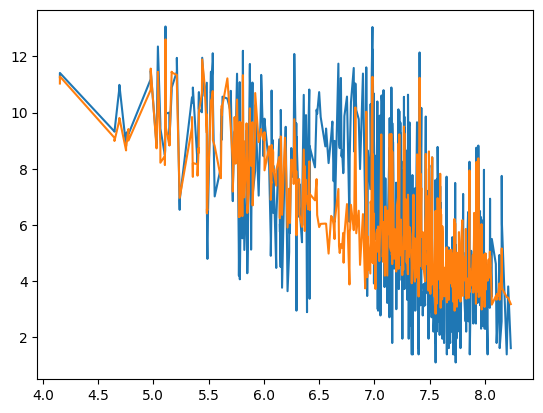

In [117]:
look_model_train_result(xgboost_model, 'Heilongjiang')